In [2]:
import pandas as pd
import matplotlib.pyplot as plt

import os
import datetime as dt

from darts.timeseries import TimeSeries as DTS
from darts.models import TCNModel
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries

from darts.metrics import mape, mae, mse, rmse
from darts import concatenate

In [2]:
def filter_time(df, t_start, t_end):
    """
    Function to filter a dataframe between t_start and t_end where time is the index
    """
    df = df.loc[ (df.index.values>=t_start) & (df.index.values<=t_end)]
    
    return df

def processdata_prosumer(df, t_start, t_end):
    
    # Convert HourUTC to timestamp
    df['HourUTC'] = pd.to_datetime(df['HourUTC'])
    # Remove timezone
    df['HourUTC'] = df['HourUTC'].dt.tz_localize(None)   
    # Set HourUTC as index
    df.set_index('HourUTC', inplace = True)
    # Calculate hourly average
    df = df.resample('H').mean()
    # Filter the dataframe for time
    df = filter_time(df, t_start, t_end)
    # Sort the dataframe
    df = df.sort_index()
    
    df_load = df[['Load']]
    df_exo = df[['PV']]

    return df_load, df_exo

def processdata_weather(df, t_start, t_end):
    
    # Convert HourUTC to timestamp
    df["PeriodStart"] = pd.to_datetime(df["PeriodStart"], utc=True)
    df.rename(columns = {'PeriodStart':'HourUTC'}, inplace = True)
    # # Convert HourUTC to timestamp
    # df['HourUTC'] = pd.to_datetime(df['HourUTC'])
    # Remove timezone
    df['HourUTC'] = df['HourUTC'].dt.tz_localize(None)
    # Set HourUTC as index
    df.set_index('HourUTC', inplace = True)
    # Filter the dataframe for time
    df = filter_time(df, t_start, t_end)
    # # Keep only DK2
    df = df.loc[df["PriceArea"]=="DK1"]
    # Sort the dataframe
    df = df.sort_index()
    df = df[['Ghi']] # Try other covariants 
    return df

C:\Users\birdl\AppData\Local\Temp\ipykernel_26816\585168289.py:18: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df = df.resample('H').mean()


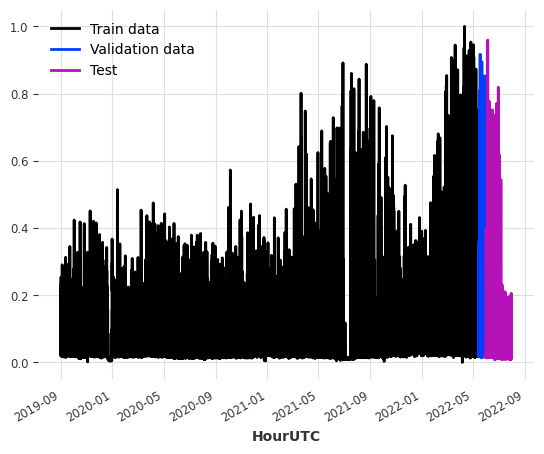

In [4]:
# Set start and end date for data processing
t_start = pd.to_datetime(dt.datetime(2019, 9, 1, 0, 0, 0))
t_end = pd.to_datetime(dt.datetime(2022, 7, 31, 23, 0, 0))

prosumer_path = os.path.join(os.getcwd(),'ProsumerData.csv')
weather_path = os.path.join(os.getcwd(),'WeatherData.csv')

df_prosumer =  pd.read_csv(prosumer_path)

df_w = pd.read_csv(weather_path)

df_load, df_PV = processdata_prosumer(df_prosumer, t_start, t_end)

df_w = processdata_weather(df_w, t_start, t_end)


series_load = DTS.from_dataframe(df_load)
series_PV = DTS.from_dataframe(df_PV)
series_weather = DTS.from_dataframe(df_w)

# series_price=DTS.from_dataframe(df_prices) # For Assignment


# Date for Train Test Split 
trainval_testsplit = "20220601" # data will be split after  

#transforming data
# For more info : https://unit8co.github.io/darts/generated_api/darts.dataprocessing.transformers.scaler.html
scaler = Scaler()
series_load_transformed = scaler.fit_transform(series_load)
scaler_exo = Scaler()
series_PV_transformed = scaler_exo.fit_transform(series_PV)
scaler_cov = Scaler()
series_weather_transformed = scaler_cov.fit_transform(series_weather)

# Try
# print(max(series_load.values()))
# print(max(series_load_transformed.values()))

#Dividing into test and training set
train_val_load_transformed, test_load_transformed = series_load_transformed.split_after(
    pd.Timestamp(trainval_testsplit)
)

# Training set is further divided into training and validation
train_valsplit = "20220515" # data will be split to validation set after 

train_load_transformed, val_load_transformed = train_val_load_transformed.split_after(
    pd.Timestamp(train_valsplit)
)



# add the day as a covariate
day_series = datetime_attribute_timeseries(
    series_load_transformed, attribute="hour" , one_hot=True
)


scaler_day = Scaler()
day_series = scaler_day.fit_transform(day_series)

#Combining exogenous variable with day
#allCov = day_series.stack(series_PV_transformed)
allCov = concatenate([day_series, series_PV_transformed, series_weather_transformed], axis=1)
# For more information : https://unit8co.github.io/darts/userguide/covariates.html

train_load_transformed.plot(label="Train data")
val_load_transformed.plot(label="Validation data")
test_load_transformed.plot(label="Test")

In [5]:
#For more info: https://unit8co.github.io/darts/generated_api/darts.models.forecasting.tcn_model.html
model_en = TCNModel(
    input_chunk_length=72, # Try testing different values eg 120
    output_chunk_length=24,
    n_epochs=5, # 50 epochs will take 15-20 min; default is 100 epochs
    dropout=0.1,
    dilation_base=2, # Try other values. Preferably below the kernal size
    weight_norm=True,
    kernel_size=3, #Try updating this value for eg try 8
    num_filters=4, #Try updating this value for eg try 20
    nr_epochs_val_period=1, 
    random_state=0,
)

In [6]:
model_en.fit(
    series=train_load_transformed,
    past_covariates=allCov,
    val_series=val_load_transformed,
    val_past_covariates=allCov,
    verbose=False,    
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=5` reached.


In [7]:
#For more info: https://unit8co.github.io/darts/generated_api/darts.models.forecasting.tcn_model.html#darts.models.forecasting.tcn_model.TCNModel.backtest
backtest_start_date = pd.to_datetime('20220601')
backtest_en = model_en.historical_forecasts(
    series=series_load_transformed,
    past_covariates=allCov,
    start=backtest_start_date,
    forecast_horizon=24,
    stride=1,
    retrain=False,
    verbose=False,
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU ava

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


MAE = 0.0699
MAPE = 69.14%
RMSE = 0.1398
MSE = 0.0195


Predicting: 0it [00:00, ?it/s]

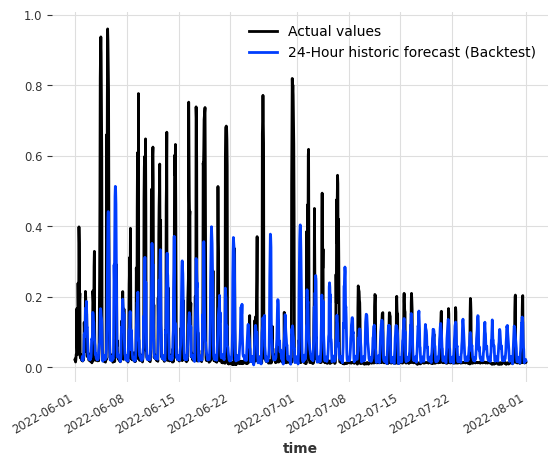

In [12]:
series_load_transformed[backtest_start_date:].plot(label="Actual values")
backtest_en.plot(label="24-Hour historic forecast (Backtest)")
plt.legend()

print("MAE = {:.4f}".format(mae(backtest_en, series_load_transformed)))
print("MAPE = {:.2f}%".format(mape(backtest_en, series_load_transformed)))
print("RMSE = {:.4f}".format(rmse(backtest_en, series_load_transformed)))
print("MSE = {:.4f}".format(mse(backtest_en, series_load_transformed)))

#  After tunning the hyper parameters test the model
prediction_transformed = model_en.predict(48, series=train_val_load_transformed, past_covariates=allCov)
prediction=scaler.inverse_transform(prediction_transformed).pd_dataframe()


In [3]:
def function(train_load_transformed, allCov, val_load_transformed,series_load_transformed, backtest_start_date):
    #For more info: https://unit8co.github.io/darts/generated_api/darts.models.forecasting.tcn_model.html
    model_en = TCNModel(
        input_chunk_length=72, # Try testing different values eg 120
        output_chunk_length=24,
        n_epochs=5, # 50 epochs will take 15-20 min; default is 100 epochs
        dropout=0.1,
        dilation_base=2, # Try other values. Preferably below the kernal size
        weight_norm=True,
        kernel_size=3, #Try updating this value for eg try 8
        num_filters=4, #Try updating this value for eg try 20
        nr_epochs_val_period=1, 
        random_state=0,
    )
    model_en.fit(
        series=train_load_transformed,
        past_covariates=allCov,
        val_series=val_load_transformed,
        val_past_covariates=allCov,
        verbose=False,    
    )
    #For more info: https://unit8co.github.io/darts/generated_api/darts.models.forecasting.tcn_model.html#darts.models.forecasting.tcn_model.TCNModel.backtest
    backtest_start_date = pd.to_datetime('20220601')
    backtest_en = model_en.historical_forecasts(
        series=series_load_transformed,
        past_covariates=allCov,
        start=backtest_start_date,
        forecast_horizon=24,
        stride=1,
        retrain=False,
        verbose=False,
    )
    
    series_load_transformed[backtest_start_date:].plot(label="Actual values")
    backtest_en.plot(label="24-Hour historic forecast (Backtest)")
    plt.legend()

    print("MAE = {:.4f}".format(mae(backtest_en, series_load_transformed)))
    print("MAPE = {:.2f}%".format(mape(backtest_en, series_load_transformed)))
    print("RMSE = {:.4f}".format(rmse(backtest_en, series_load_transformed)))
    print("MSE = {:.4f}".format(mse(backtest_en, series_load_transformed)))

    #  After tunning the hyper parameters test the model
    prediction_transformed = model_en.predict(48, series=train_val_load_transformed, past_covariates=allCov)
    prediction=scaler.inverse_transform(prediction_transformed).pd_dataframe()
    